In [1]:
# !pip install pycuda

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from PIL import Image
import time

In [3]:
source_kernel="""
__global__ void Normal_conv(float *N, float *F, float *P, int height, int width,int r)
{
  int outRow = blockIdx.y*blockDim.y +threadIdx.y;
  int outCol = blockIdx.x*blockDim.x +threadIdx.x;

  float Pvalue = 0.0f;
if (outRow < height && outCol < width)
  {
    for (int frow = 0; frow<2*r+1;frow++)
          for (int fcol = 0; fcol<2*r+1;fcol++)
          {
           int  inRow = outRow -r +frow;
           int  inCol = outCol -r +fcol;

              if ((inRow)>=0 &&(inRow)<height && (inCol)>=0 && (inCol)<width)
                {
                  Pvalue+=F[frow*(2*r + 1)+fcol]*N[inRow*width+inCol];
                }
}

          P[outRow*width+outCol]=Pvalue;
}

}
"""

In [4]:
print("Compiling the CUDA Kernel....")
#compile the cuda

mode =  SourceModule(source_kernel)

#Get the compiler function from the compile module
image_conv= mode.get_function('Normal_conv')


print("kernel compiled successfully")

Compiling the CUDA Kernel....
kernel compiled successfully


The image is loaded successfully
The matrix of Bukayo Saka is now initialised


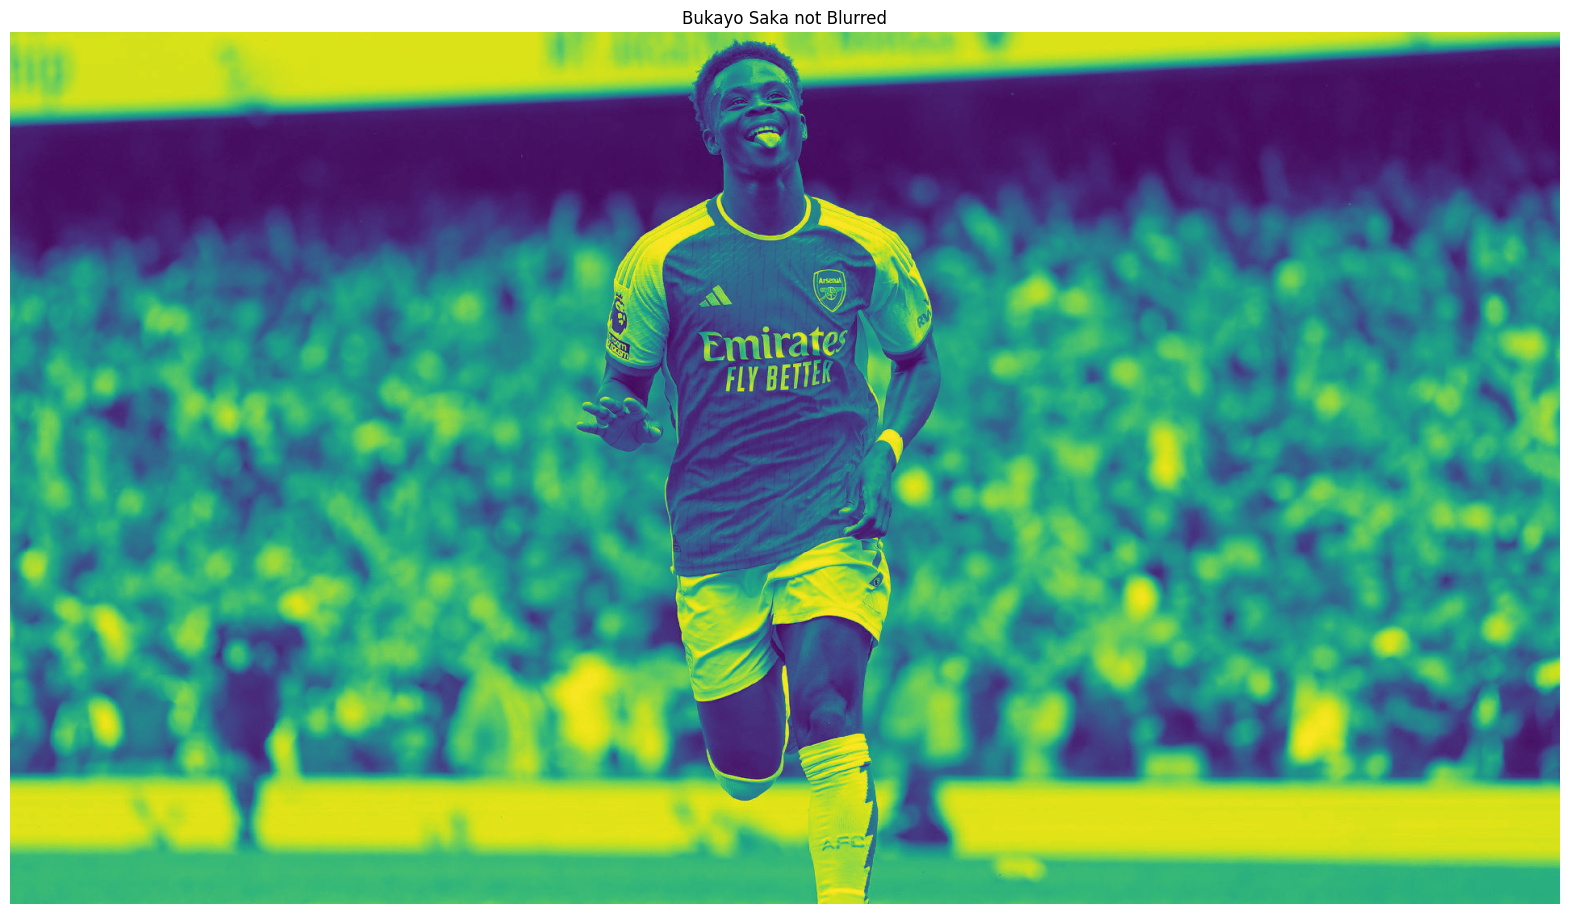

In [5]:
#Load the grayscale image and view
image = np.array(Image.open("Saka_gray.jpg"))
print("The image is loaded successfully")

#View the image
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
plt.axis("off")
plt.title("Bukayo Saka not Blurred")
ax.imshow(image)
print("The matrix of Bukayo Saka is now initialised")

In [6]:
#print the shape of the input array
print(f'The shape of the input array is {image.shape}')

#Initialise an empy array for result
empty_sample_output=np.empty_like(image)

print('\nEmpty output image is initialised')

The shape of the input array is (1080, 1920)

Empty output image is initialised


In [7]:
#initialise the kernel
kernel= np.array(
[[-1 , -4  ,-6  ,-4 ,-1],
 [-2 ,-8 ,-12  ,-8  ,-2],
 [0  , 0 ,  0 ,  0   ,0],
 [2,   8  ,12,   8,   2],
 [1  , 4 ,  6   ,4  , 1]])
print(f"The kernel is now  with shape {kernel.shape}")

The kernel is now  with shape (5, 5)


In [8]:
#Allocate memory in GPY

image = image.astype(np.float32)
kernel = kernel.astype(np.float32)
empty_sample_output = np.zeros_like(image, dtype=np.float32)

p_in= cuda.mem_alloc(image.nbytes)
kernel_gpu =cuda.mem_alloc(kernel.nbytes)
p_out=cuda.mem_alloc(empty_sample_output.nbytes)

print("memory allocated in GPU")

memory allocated in GPU


In [9]:
#Transfer Data from CPu to Gpu
print("Copy the image to GPU form the CPU")
cuda.memcpy_htod(p_in,image)
cuda.memcpy_htod(kernel_gpu,kernel)
print("\nCopying completed")

Copy the image to GPU form the CPU

Copying completed


In [10]:
#Execute the kernel in GPU
print("\nExecuting the parallel programming in GPU")
#Define the Block and grid dimension in GPU to process
# A block is a group of  threads . A grid is a group of blocks
BLOCK_SIZE=(16,16,1)
GRID_SIZE = (
    (image.shape[1]+BLOCK_SIZE[0]-1)//BLOCK_SIZE[0],
    (image.shape[0]+BLOCK_SIZE[0]-1)//BLOCK_SIZE[0],1
    )

#Start the time

gpu_start_time= time.time()

#Call the Kernel
image_conv(p_in,kernel_gpu,p_out,np.int32(image.shape[0]),np.int32(image.shape[1]),np.int32(kernel.shape[1]//2),block =BLOCK_SIZE,grid=GRID_SIZE)

#Wait for the GPU to Finish the Process
cuda.Context.synchronize()

#stop the timer
gpu_endtime= time.time()

gpu_execution_time=(gpu_endtime-gpu_start_time)
print("\nExection in GPU completed :)")




Executing the parallel programming in GPU

Exection in GPU completed :)


In [11]:
#Copying the result from thr GPU to CPU
print("Copying the result back to CPU")
empty_sample_output=np.empty_like(image)
cuda.memcpy_dtoh(empty_sample_output,p_out)
print("copied successfully to CPU")

Copying the result back to CPU
copied successfully to CPU


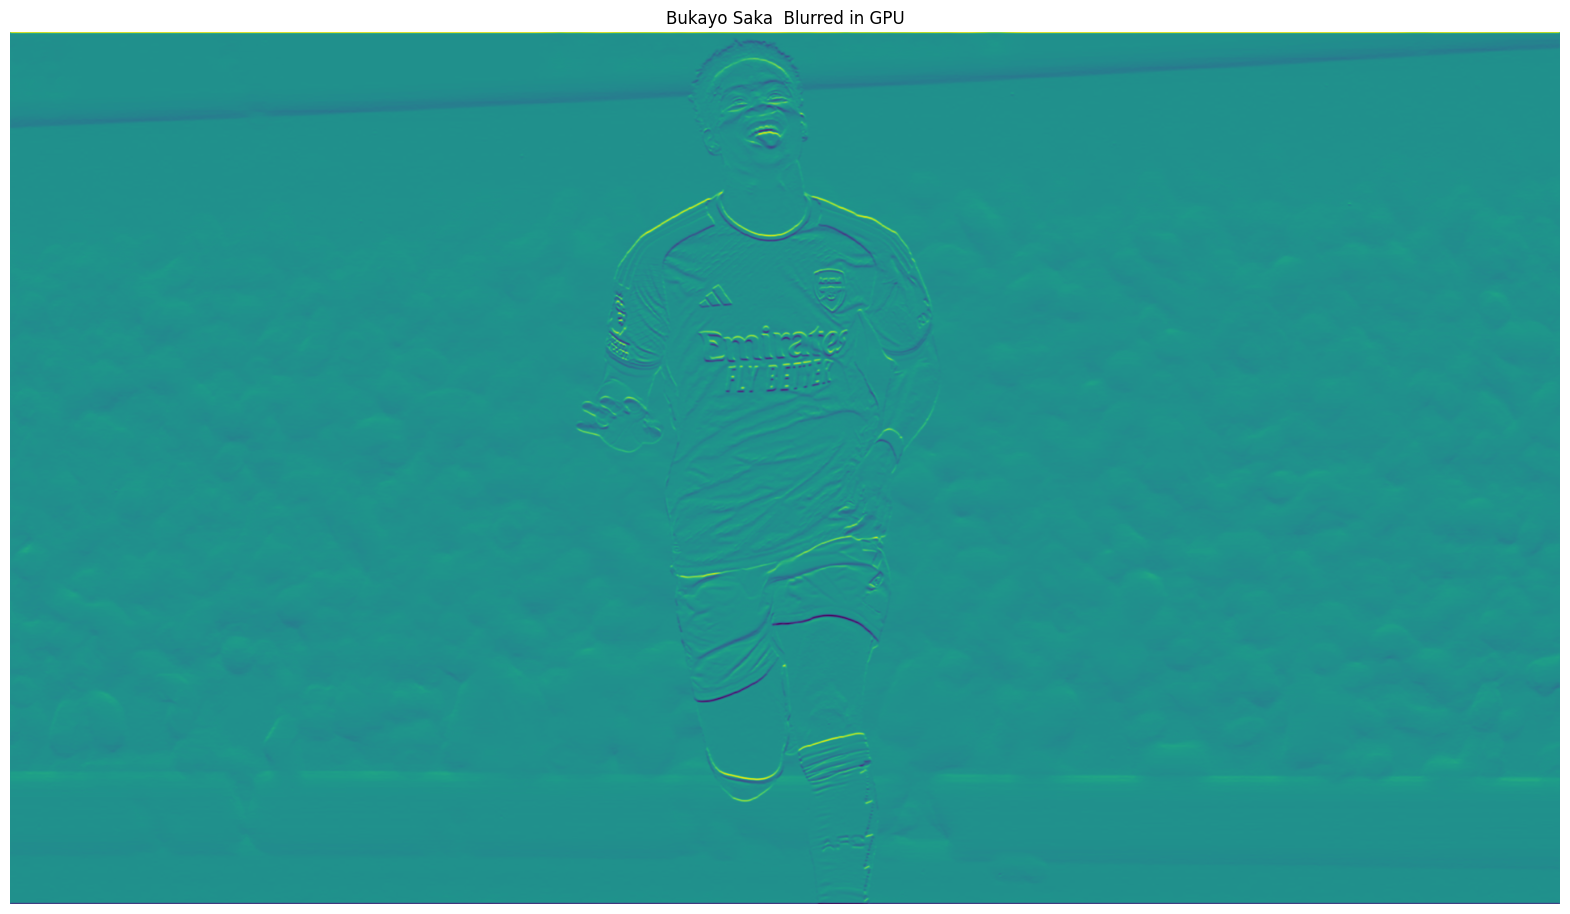

The matrix of Bukayo Saka is now is the blurred matrix


In [12]:
#Show the blurred Bukayo Saka
axes= plt.Figure(figsize=(10,9))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
plt.axis("off")
plt.title("Bukayo Saka  Edge detected in GPU")
ax.imshow(empty_sample_output)
plt.axis("off")
plt.show()
print("The matrix of Bukayo Saka is the resultant convolved Matrix")